# Pig islets - Preprocessing

In [21]:
import scanpy.api as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings

In [3]:
sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.4+317.g2024911 anndata==0.6.19+14.g81d10e2 numpy==1.16.1 scipy==1.2.1 pandas==0.23.0 scikit-learn==0.20.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


# Preprocessing

## Load data - Cellranger output files

In [9]:
# Cellranger output data Data files
sample_strings = ['pig_1', 'pig_2']

In [ ]:
adata_dict = {}

for smp in sample_strings:
    data_file = f'../data/{smp}/matrix.mtx' # make sure to adapt path to folder with CellRanger Output
    barcode_file = f'../data/{smp}/barcodes.tsv'
    gene_file = f'../data/{smp}/genes.tsv'

    adata = sc.read(data_file, cache=True).transpose()   
    adata.var_names = np.genfromtxt(gene_file, dtype=str)[:, 1]
    adata.var['gene_id'] = np.genfromtxt(gene_file, dtype=str)[:, 0]
    adata.obs_names = np.genfromtxt(barcode_file, dtype=str)
    adata.obs['sample'] = smp
    
    adata.var_names_make_unique()
    
    adata_dict[smp] = adata

In [28]:
adata01 = adata_dict['pig_1'].copy()
adata02 = adata_dict['pig_2'].copy()

## Load data - GEO h5ad-file

In [ ]:
adata01 = adata[adata.obs['sample']=='pig_1'].copy()
adata02 = adata[adata.obs['sample']=='pig_2'].copy()

## Quality Control

In [ ]:
def add_qc_metrics(adata):
    # Quality control - calculate QC covariates
    adata.obs['n_counts'] = adata.X.sum(1)
    adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
    adata.obs['n_genes'] = (adata.X > 0).sum(1)
    # fraction of mt-encoded genes per cell type
    mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
    adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']
    return adata

## Quality Control

In [ ]:
adata01 = add_qc_metrics(adata01)
adata01 = add_qc_metrics(adata02)

#### Filtering and doublet estimation for pig_1

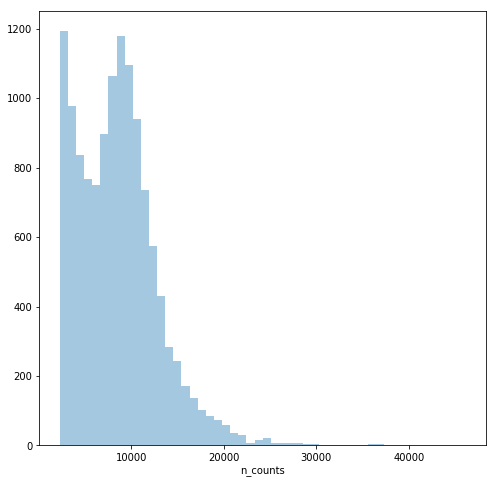

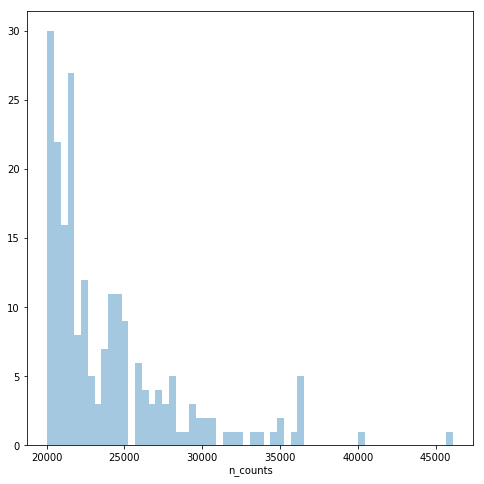

In [81]:
#Thresholding decision: counts
p3 = sb.distplot(adata01.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata01.obs['n_counts'][adata01.obs['n_counts']>20000], kde=False, bins=60)
plt.show()

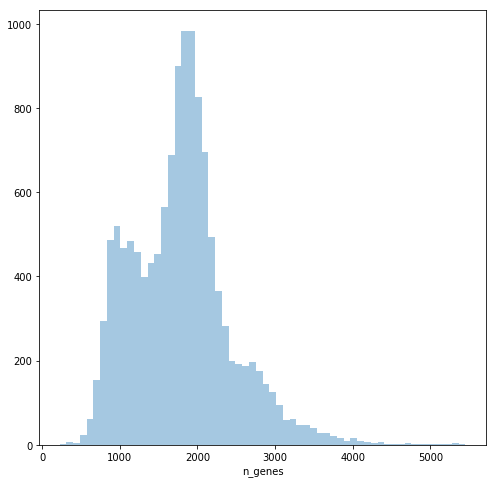

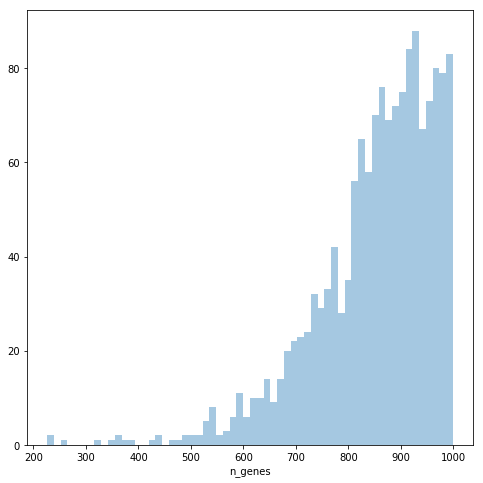

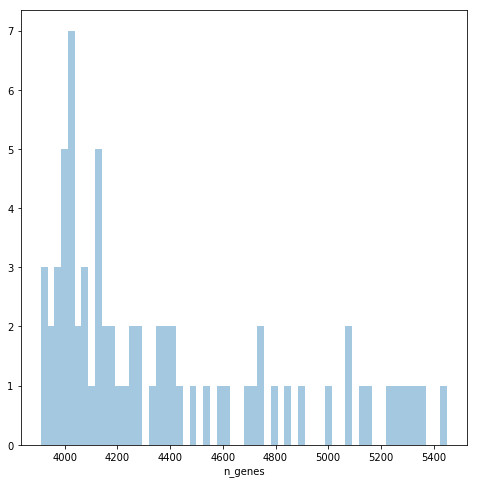

In [82]:
#Thresholding decision: genes
p5 = sb.distplot(adata01.obs['n_genes'], kde=False, bins=60)
plt.show()

p6 = sb.distplot(adata01.obs['n_genes'][adata01.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata01.obs['n_genes'][adata01.obs['n_genes']>3900], kde=False, bins=60)
plt.show()

In [ ]:
scrub = scr.Scrublet(adata01.X.copy(), expected_doublet_rate=0.06)
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

scrub.call_doublets(threshold=0.4)
adata01.obs['doublet'] = doublet_scores.values

In [83]:
# FILTER PARAMETERS pig_1
print('Total number of cells: {:d}'.format(adata01.n_obs))

#Filter out counts over 23000
sc.pp.filter_cells(adata01, max_counts = 23000)
print('Number of cells after max count filter: {:d}'.format(adata01.n_obs))

adata01 = adata01[adata01.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata01.n_obs))

#Filter out genes under 600
sc.pp.filter_cells(adata01, min_genes = 600)
print('Number of cells after gene filter: {:d}'.format(adata01.n_obs))

#Filter out genes over 3900
sc.pp.filter_cells(adata01, max_genes = 3900)
print('Number of cells after gene filter: {:d}'.format(adata01.n_obs))

Total number of cells: 12766
filtered out 94 cells that have more than  23000 counts
Number of cells after max count filter: 12672
Number of cells after MT filter: 12672
filtered out 55 cells that have less than 600 genes expressed
Number of cells after gene filter: 12617
filtered out 20 cells that have more than  3900 genes expressed
Number of cells after gene filter: 12597


#### Filtering and doublet estimation for pig_2

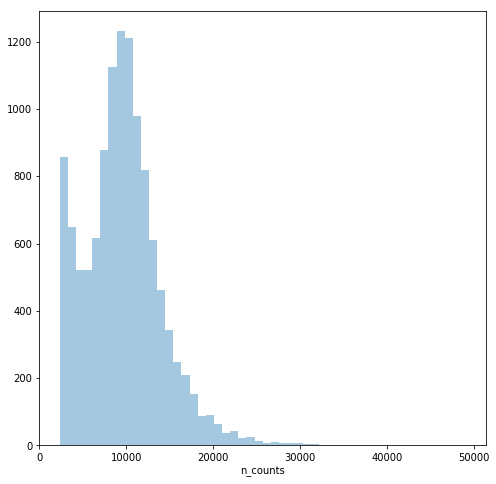

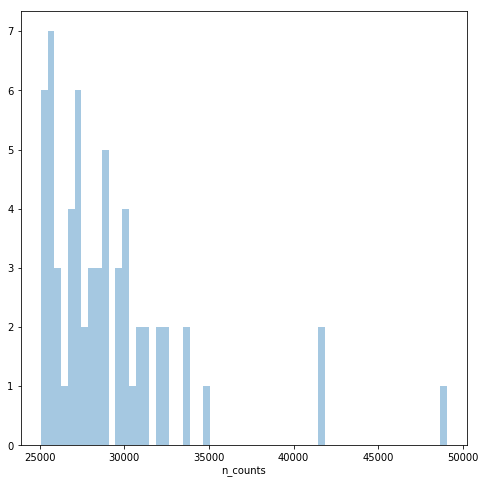

In [84]:
#Thresholding decision: counts
p3 = sb.distplot(adata02.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata02.obs['n_counts'][adata02.obs['n_counts']>25000], kde=False, bins=60)
plt.show()

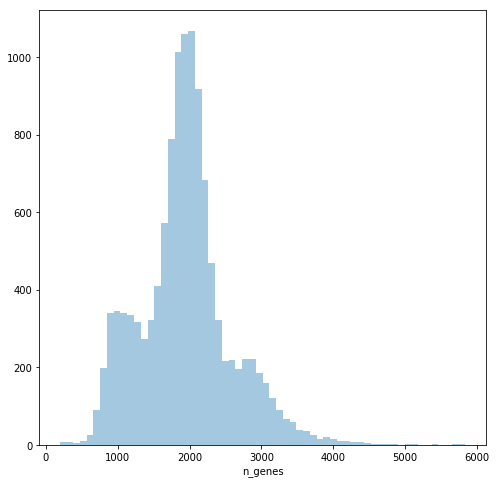

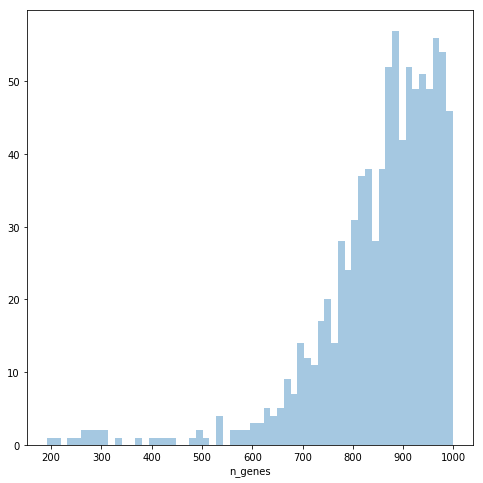

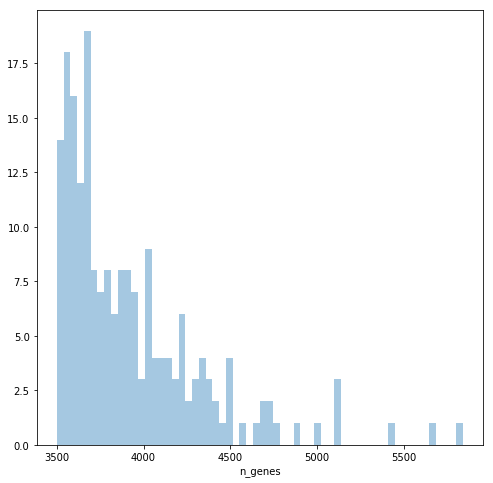

In [85]:
#Thresholding decision: genes
p5 = sb.distplot(adata02.obs['n_genes'], kde=False, bins=60)
plt.show()

p6 = sb.distplot(adata02.obs['n_genes'][adata02.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata02.obs['n_genes'][adata02.obs['n_genes']>3500], kde=False, bins=60)
plt.show()

In [ ]:
scrub = scr.Scrublet(adata02.X.copy(), expected_doublet_rate=0.06)
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

scrub.call_doublets(threshold=0.4)
adata02.obs['doublet'] = doublet_scores.values

In [86]:
# FILTER PARAMETERS pig_2
print('Total number of cells: {:d}'.format(adata02.n_obs))

#Filter out counts over 30000
sc.pp.filter_cells(adata02, max_counts = 30000)
print('Number of cells after max count filter: {:d}'.format(adata02.n_obs))

adata02 = adata02[adata02.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata02.n_obs))

#Filter out genes under 600
sc.pp.filter_cells(adata02, min_genes = 600)
print('Number of cells after gene filter: {:d}'.format(adata02.n_obs))

#Filter out genes over 4500
sc.pp.filter_cells(adata02, max_genes = 4500)
print('Number of cells after gene filter: {:d}'.format(adata02.n_obs))

Total number of cells: 12597
filtered out 18 cells that have more than  30000 counts
Number of cells after max count filter: 11852
Number of cells after MT filter: 11852
filtered out 33 cells that have less than 600 genes expressed
Number of cells after gene filter: 11819
filtered out 7 cells that have more than  4500 genes expressed
Number of cells after gene filter: 11812


### Concatenate samples

In [87]:
adata = adata01.concatenate(adata02, batch_key='sample', batch_categories=['01','02'])

### Filter genes

In [88]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 22695
filtered out 8856 genes that are detected in less than 20 cells
Number of genes after cell filter: 13839


## SCRAN normalization

In [1]:
adata_pp = adata.copy()

In [93]:
#Perform a clustering for scran normalization in clusters
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

In [2]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [ ]:
%%R -i data_mat -i input_groups -o size_factors
require(scran)

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [ ]:
adata.obs['size_factors'] = size_factors

In [ ]:
#Delete adata_pp
del adata_pp

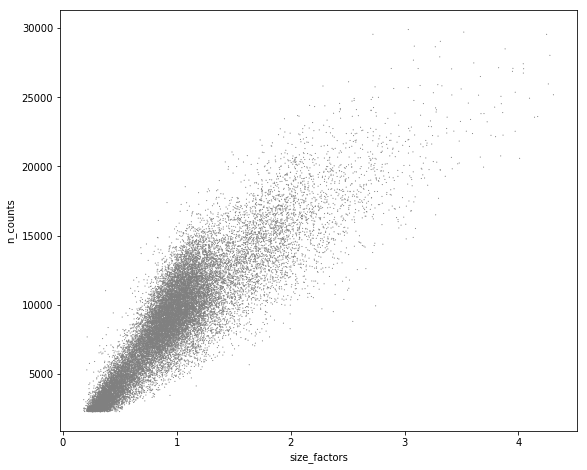

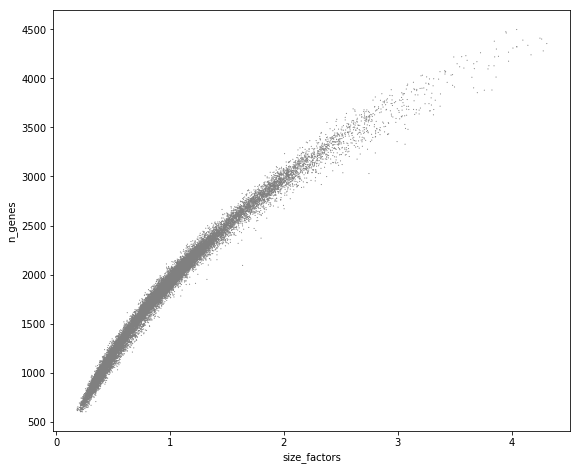

In [106]:
# Visualize the estimated size factors
sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

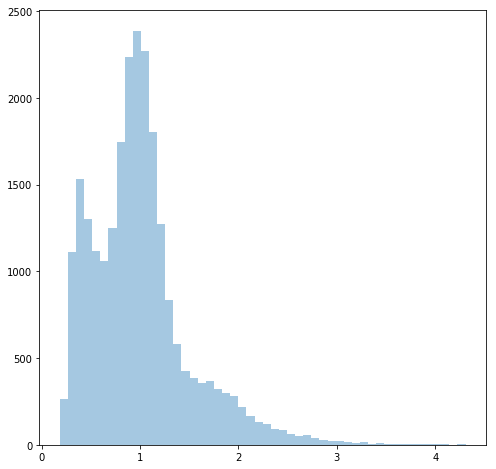

In [11]:
sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [ ]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [ ]:
# Normalize data
adata.X /= adata.obs['size_factors'].values[:, None]

In [ ]:
# log transform
sc.pp.log1p(adata)

## Combat Batch correction

In [ ]:
#Before batch correction - quick selection of HVGs and UMAP calculation
sc.pp.filter_genes_dispersion(adata, flavor='cell_ranger', n_top_genes=4000, log=False, subset=False)
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

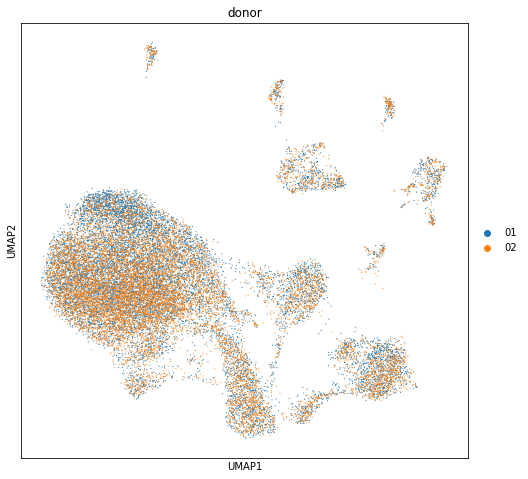

In [22]:
sc.pl.umap(adata, color='donor')

In [6]:
# Use Combat
sc.pp.combat(adata, key='sample')

Standardizing Data across genes.

Found 5 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments



/home/icb/moritz.thomas/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:269: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_it_sol" failed type inference due to: Cannot unify array(float64, 2d, C) and array(float64, 1d, C) for 'sum2', defined at /home/icb/moritz.thomas/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py (311)

File "../miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py", line 311:
def _it_sol(s_data, g_hat, d_hat, g_bar, t2, a, b, conv=0.0001) -> Tuple[float, float]:
    <source elided>
        g_new = (t2*n*g_hat + d_old*g_bar) / (t2*n + d_old)
        sum2 = s_data - g_new.reshape((g_new.shape[0], 1)) @ np.ones((1, s_data.shape[1]))
        ^

[1] During: typing of assignment at /home/icb/moritz.thomas/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py (313)

File "../miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_comb

Adjusting data



In [ ]:
# set 0 counts to 0
adata.X[adata.layers['counts']==0]=0
adata.X=csr_matrix(adata.X)

In [ ]:
# remove counts to save memory
del adata.layers['counts']

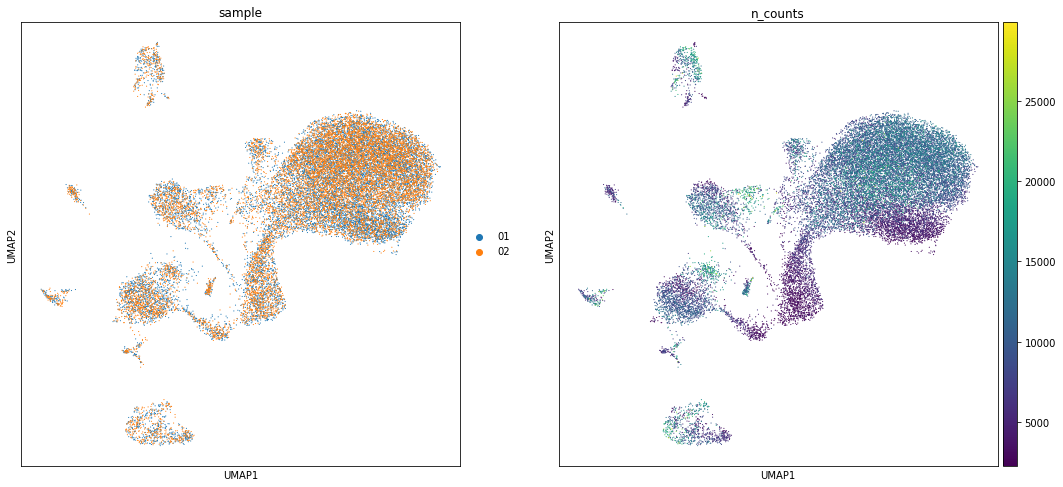

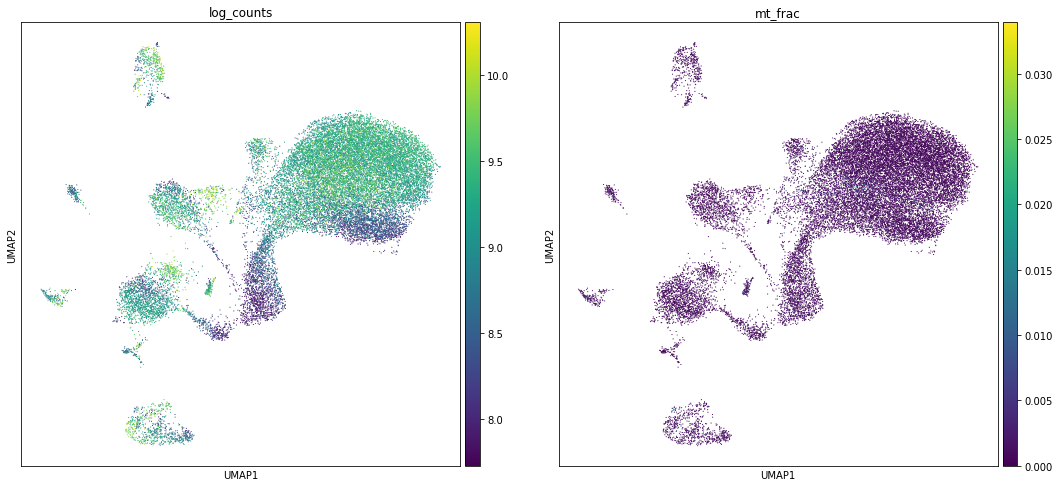

In [25]:
#After batch correction - Quick selection of HVGs and UMAP calculation
adata_bc = adata.copy()
sc.pp.filter_genes_dispersion(adata_bc, flavor='cell_ranger', n_top_genes=4000, log=False, subset=False)
sc.pp.pca(adata_bc, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_bc)
sc.tl.umap(adata_bc)

sc.pl.umap(adata_bc, color=['sample', 'n_counts'])
sc.pl.umap(adata_bc, color=['log_counts', 'mt_frac'])

In [10]:
adata.write('../data/pig_norm.h5ad')